# PanDelos-Plus analysis

In [ ]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

sys.path.append('Code/')
from dataset import process_data


In [ ]:
def clean_ds_store(directory='.'):
    """
    Remove all '.DS_Store' files from the specified directory and its subdirectories. (Mac OS)
    """
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == '.DS_Store':
                file_path = os.path.join(root, file)
                os.remove(file_path)

clean_ds_store()

### Parse PanDelos-Plus output

In [2]:
def clean_strain_name(strain):
    if strain.startswith("GCA"):
        return strain.split(".", 1)[0]  # Mantiene solo la parte prima del primo punto
    else:
        return ".".join(strain.split(".")[:2])  # Mantiene solo la parte prima del secondo punto


def parse_clus(path="Result/PanDelos-plus/out.clus", save=False):
    """
        Converts the clus file produced by PanDelos into a more readibler Excel format.
        
        Note: If the gene family did not have a specified locus tag, default values for 
        start, end, and helix have been set.
    """

    out = {
        'Strain': [],
        'Gene family': [],
        'Sequence': [],
        'Counter': [],
        'Locus tag': [],
        'Start': [],
        'End': [],
        'Helix': []
    }

    with open(path, "r") as f:
        lines = f.readlines()

    i = 1
    for gene_families in lines:
        gene_family_name = i
        i = i + 1

        genes = gene_families.strip().split(" ")

        for gene in genes:
            gene_info = gene.split(":")

            # Avoid unknown locus_tag
            if len(gene_info) >= 3 and gene_info[2].startswith("unknown"):
                continue

            genome_name, sequence, other_info_raw, counter = gene_info
            locus_tag, *other_info = other_info_raw.split(";")  # *other_info è una lista
            
            if locus_tag != "N/A":
                start, end, helix = other_info[0:3]
            else:
                start, end, helix = 0, 0, 0

            out['Strain'].append(genome_name)
            out['Gene family'].append(gene_family_name)
            out['Sequence'].append(sequence)
            out['Counter'].append(counter)
            out['Locus tag'].append(locus_tag)
            out['Start'].append(start) # Tolto il + 1 -> Avoid a problem -> TODO: check nei gbff e poi nei bgk
            out['End'].append(end)
            out['Helix'].append(helix)

    out = pd.DataFrame(out).sort_values(by=['Gene family'], ascending=[True])
    out["Strain"] = out["Strain"].apply(clean_strain_name)


    if save:
        dir, file = os.path.split(path)
        name, _ = os.path.splitext(file)
        out_path = os.path.join(dir, name + '.xlsx')
        
        # Disabilitare il salvataggio se il file .clus ha troppe righe/geni
        with pd.ExcelWriter(out_path) as writer:
            out.to_excel(writer, index=False)
        print(f"File {name} converted to excel file and saved in {out_path}.")

    return out

Elabora il file .clus calcolato dal software PanDelos-Plus

In [3]:
gene_families = parse_clus(path="Result/PanDelos-plus/out.clus", save=False)

# gene_families = pd.read_excel("Result/PanDelos-plus/out.xlsx")
# display(gene_families)

### Compute diffusivity

#### Functions

In [4]:
def calculate_diffusivity(gene_families, carbohydrate='general'):
    """
    Calcola la diffusività delle famiglie geniche (numero di genomi distinti in cui appare almeno un gene della famiglia)
    e la distribuzione delle frequenze di diffusività.
    """

    os.makedirs("Result/Diffusivity/", exist_ok=True)

    # Calcolo diffusività
    diffusivity = gene_families.groupby('Gene family')['Strain'].nunique()
    out = diffusivity.reset_index()
    out.columns = ["Gene family", "Diffusivity"]
    out = out[['Gene family', 'Diffusivity']].drop_duplicates()

    # Calcolo frequenze delle diffusività
    diffusivity_frequency = diffusivity.value_counts().sort_index().reset_index()
    diffusivity_frequency.columns = ["Diffusivity", "Frequency"]

    if carbohydrate == 'general':
        out.to_excel("Result/Diffusivity/diffusivity.xlsx", index=False)
        diffusivity_frequency.to_excel("Result/Diffusivity/diffusivity_frequency.xlsx", index=False)
    else:
        os.makedirs(f"Result/Diffusivity/{carbohydrate}", exist_ok=True)
        out.to_excel(f"Result/Diffusivity/{carbohydrate}/diffusivity.xlsx", index=False)
        diffusivity_frequency.to_excel(f"Result/Diffusivity/{carbohydrate}/diffusivity_frequency.xlsx", index=False)
        
    return out, diffusivity_frequency

#### General diffusivity


In [ ]:
diffusivity, diffusivity_frequency = calculate_diffusivity(gene_families)

display(diffusivity)
display(diffusivity_frequency)

,Gene family,Diffusivity
0,1,2
1,2,26
2,3,1
3,4,2
4,5,4
...,...,...
424936,424937,1
424937,424938,1
424938,424939,1
424939,424940,1


,Diffusivity,Frequency
0,1,295680
1,2,58653
2,3,23479
3,4,14266
4,5,6942
...,...,...
213,303,1
214,304,1
215,305,2
216,378,1


#### Positive diffusivity


In [ ]:
X, y = process_data("Data/")

gene_families_cleaned = gene_families.copy()
gene_families_cleaned["Strain"] = gene_families_cleaned["Strain"].str.split(r"[._]").str[0:2].str.join(".") # Clean strain string

for carbohydrate in y.columns:
    print(f"Calcolo diffusività su famiglie geniche di positivi e negativi di {carbohydrate}")
    positive_genomes = X[y[carbohydrate] == 1].index
    negative_genomes = X[y[carbohydrate] == 0].index

    gene_families_positive = gene_families_cleaned[gene_families_cleaned['Strain'].isin(positive_genomes)]
    gene_families_negative = gene_families_cleaned[gene_families_cleaned['Strain'].isin(negative_genomes)]

    _, _ = calculate_diffusivity(gene_families_positive, carbohydrate=f"{carbohydrate}_positive")
    _, _ = calculate_diffusivity(gene_families_negative, carbohydrate=f"{carbohydrate}_negative")


Calcolo diffusività su famiglie geniche di positivi e negativi di GLYcerol
Calcolo diffusività su famiglie geniche di positivi e negativi di ERYthritol
Calcolo diffusività su famiglie geniche di positivi e negativi di D-ARAbinose
Calcolo diffusività su famiglie geniche di positivi e negativi di L-ARAbinose
Calcolo diffusività su famiglie geniche di positivi e negativi di D-RIBose
Calcolo diffusività su famiglie geniche di positivi e negativi di D-XYLose
Calcolo diffusività su famiglie geniche di positivi e negativi di L-XYLose
Calcolo diffusività su famiglie geniche di positivi e negativi di D-ADOnitol
Calcolo diffusività su famiglie geniche di positivi e negativi di Methyl-ßD-Xylopyranoside
Calcolo diffusività su famiglie geniche di positivi e negativi di D-GALactose
Calcolo diffusività su famiglie geniche di positivi e negativi di D-GLUcose
Calcolo diffusività su famiglie geniche di positivi e negativi di D-FRUctose
Calcolo diffusività su famiglie geniche di positivi e negativi di D-

## Estrazione geni più impattanti

A partire dai geni estratti dai metodi utilizzati in questo progetto (importanza feature, OD e raggruppamento tramite Product), si estraggono i geni e le famiglie geniche che sono state calcolate da PanDelos-Plus dai risultati calcolati in questo progetto, valutando le performance di questi metodi guardando l'importanza di ciascun gene/famiglia genica.

spiegare meglio

In [ ]:
def convert_helix_values(value):
    """
        Converts string values ('-1', '1') into corresponding symbols ('-', '+').
        This conversion is relevant for helices in DNA sequences as reported in the output file from PanDelos.
    """

    if value == "-1":
        return "-"
    elif value == "1":
        return "+"
    else:
        return value
    

def gene_importances_pandelos(gene_families, y):
    """
    TODO Descrizione corretta ma breve: mappa le importanze dei geni calcolate dai modelli di ML sui geni che PanDelos ha restituito

    -Legge l excel con tutti i geni (coperti e non coperti dall'AFLP)
    -Dalle famiglie geniche estratte da pandelos, estrae le righe che contengono solo il genoma corrente
    -Aggiunge le informazioni di cfopertura ed importanza se presenti
    -Restituisce il df originale delle famiglie geniche estratte da pandelos con l'aggiunta delle informazioni di importanza e copertura:
    ci potrebbero quindi essere tantissime righe che non hanno i valori per le colonne aggiunte poichè il gene non era presente nel file analizzato
    (nelle fasi precedenti potrebbe essere stato scartato a causa di errori o alcuni valori mancanti)
    -ci potrebbero essere casi in cuiil df di output è vuoto poichè c'erano pochissime famiglie geniche che contenevano quel genoma e quei geni individuati
    non erano nemmeno presenti nei file analizzati
    """

    clean_ds_store()

    output = dict()
    input_path = 'Result/Coverages/Gene_Importances/'
    output_path = 'Result/Coverages/Gene_Importances_Pandelos/'
    os.makedirs(output_path, exist_ok=True)

    y.columns = y.columns.str.strip()  # Rimuove eventuali spazi vuoti nei nomi delle colonne

    for carbohydrate in os.listdir(input_path):
        
        print(f'Calculating genes importances for carbohydrate {carbohydrate}.')
        
        out = pd.DataFrame()
        carb_path = os.path.join(input_path, carbohydrate)

        if not os.path.isdir(carb_path) or carbohydrate not in y.columns:
            continue  # Evita errori se il percorso non è valido o la colonna non esiste

        xlsx_files = [f for f in os.listdir(carb_path) if f.endswith('.xlsx')]
        dataframes = [(file, pd.read_excel(os.path.join(carb_path, file))) for file in xlsx_files]

        # Legge le importanze di ogni gene di un genoma
        for file, genes in dataframes:

            genome = os.path.splitext(file)[0]
            extracted_genes = gene_families[gene_families['Strain'] == genome].copy()
            
            extracted_genes['Helix'] = extracted_genes['Helix'].apply(convert_helix_values).astype(str)
            genes['Helix'] = genes['Helix'].astype(str)
            extracted_genes = extracted_genes[extracted_genes['Helix'] != '0']  # Non considero geni senza informazioni

            if extracted_genes.empty:
                continue

            extracted_genes['Start'] = extracted_genes['Start'].astype(int) + 1 # Avoid index problems
            extracted_genes['End'] = extracted_genes['End'].astype(int)
            extracted_genes['Locus tag'] = extracted_genes['Locus tag'].astype(str)
            genes['Start'] = genes['Start'].astype(int)
            genes['End'] = genes['End'].astype(int)
            genes['Locus tag'] = genes['Locus tag'].astype(str)

            extracted_genes = pd.merge(
                extracted_genes, genes,
                on=['Sequence', 'Locus tag', 'Start', 'End', 'Helix'],
                how='left'
            )

            out = pd.concat([out, extracted_genes], axis=0, ignore_index=True)

        #     print("Rows with missing values after merge:")
        #     print(extracted_genes[extracted_genes.isna().any(axis=1)])
        #     display(extracted_genes[extracted_genes['Locus tag'] == 'FD00_GL000052'])
        #     display(genes[genes['Locus tag'] == 'FD00_GL000052'])
        # display(out[out['Locus tag'] == 'FD00_GL000052'])

        if not out.empty:
            save_path = os.path.join(output_path, f"{carbohydrate}.xlsx")
            out.to_excel(save_path, index=True)

        output[carbohydrate] = out

    print(f'Results saved in {output_path}')

    return output


_, y = process_data("Data/")
gene_importances = gene_importances_pandelos(gene_families, y)

In [12]:
def analyze_gene_families(y):
    """
        Accorpa i geni secondo l'idea che le famiglie geniche hanno lo stesso Product. 
        TODO: Scegliere un nome adatto alla funzione.
    """
    clean_ds_store()

    path = 'Result/Coverages/Gene_Importances_Pandelos/'
    output_path = 'Result/Coverages/Common_Genes_Pandelos/'
    os.makedirs(output_path, exist_ok=True)

    # output = pd.DataFrame(columns=['Gene family', 'Positive importance', 'Negative importance', 'Ratio', 'Product'])
    
    for file in os.listdir(path):
        print(f'Calculating common genes for carbohydrate {file}.')

        genes = pd.read_excel(os.path.join(path, file))
              
        carbohydrate = os.path.splitext(file)[0]        # Elimina estensione
        genes['Strain'] = genes['Strain'].astype(str)   # Conversione in stringa per effettuare confronti

        positive_strain = y[y[carbohydrate] == 1].index.to_list()
        positive_strain = [str(s) for s in positive_strain]
        negative_strain = y[y[carbohydrate] == 0].index.to_list()
        negative_strain = [str(s) for s in negative_strain]

        positives = genes[genes['Strain'].isin(positive_strain)]
        negatives = genes[genes['Strain'].isin(negative_strain)]
        positives["Type"] = "Positive"
        negatives["Type"] = "Negative"
        combined = pd.concat([positives, negatives])

        # Raggruppa i dati per "Product" e "Type"
        grouped = combined.groupby(["Product", "Type"], as_index=False).agg({
            "Importance": "mean",                   # Calcola la media delle importanze
            "Gene family": lambda x: list(set(x))   # Crea una lista unica di famiglie geniche
        })

        summary = grouped.pivot(index="Product", columns="Type", values=["Importance", "Gene family"])   # Riorganizza i dati in modo più leggibile

        expected_columns = {
            ("Importance", "Positive"): "Positive importance",
            ("Importance", "Negative"): "Negative importance",
            ("Gene family", "Positive"): "Gene family Pos",
            ("Gene family", "Negative"): "Gene family Neg",
        }
        summary.columns = [expected_columns[col] for col in summary.columns if col in expected_columns]

        for col in ["Gene family Pos", "Gene family Neg"]: # Assicura che le colonne di famiglie geniche siano sempre liste (evita NaN)
            if col in summary.columns:
                summary[col] = summary[col].apply(lambda x: x if isinstance(x, list) else [])

        # Unisci le famiglie geniche in un'unica colonna
        if "Gene family Pos" in summary.columns and "Gene family Neg" in summary.columns:
            summary["Gene family PanDelos"] = summary.apply(lambda row: list(set(row["Gene family Pos"] + row["Gene family Neg"])), axis=1)
        elif "Gene family Pos" in summary.columns:
            summary["Gene family PanDelos"] = summary["Gene family Pos"]
        elif "Gene family Neg" in summary.columns:
            summary["Gene family PanDelos"] = summary["Gene family Neg"]
        else:
            summary["Gene family PanDelos"] = []

        summary = summary.drop(columns=[col for col in ["Gene family Pos", "Gene family Neg"] if col in summary.columns]).reset_index()


        if "Positive importance" in summary.columns and "Negative importance" in summary.columns:
            p = summary["Positive importance"].fillna(0)
            n = summary["Negative importance"].fillna(0)

            summary["Ratio Pos/Neg"] = np.where(n != 0, p / n, np.nan)

            # Calcolo del coseno tra (p, n) e l'origine
            A = p / np.sqrt(p**2 + n**2)  
            B = 1 / np.sqrt(2)
            summary["Cosine Difference"] = B - A

        # display(summary)

        summary = summary.sort_values(by=['Positive importance','Negative importance'], ascending=[False,False]).reset_index(drop=True)
        summary.index += 1
        summary.index.name = 'Rank'

        if not summary.empty:
            save_path = os.path.join(output_path, f"{carbohydrate}.xlsx")
            summary.to_excel(save_path, index=True)
    
    print(f'\nCommon genes importances saved in {output_path}.')
    return summary

analyzed_gene_families = analyze_gene_families(y)

Calculating common genes for carbohydrate potassium 2-KetoGluconate.xlsx.


Exception ignored in: <function ZipFile.__del__ at 0x106004ca0>
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/zipfile.py", line 1807, in __del__
    self.close()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/zipfile.py", line 1824, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Calculating common genes for carbohydrate D-RAFfinose.xlsx.
Calculating common genes for carbohydrate D-RIBose.xlsx.
Calculating common genes for carbohydrate ARButin.xlsx.
Calculating common genes for carbohydrate D-CELlobiose.xlsx.
Calculating common genes for carbohydrate potassium 5-KetoGluconate.xlsx.
Calculating common genes for carbohydrate D-FRUctose.xlsx.
Calculating common genes for carbohydrate D-MELibiose.xlsx.

Common genes importances saved in Result/Coverages/Common_Genes_Pandelos/.


# Density plot Diffusività - Importanza

In [47]:
def plot_diffusivity_importance(positives, negatives, all_genomes, y, carbohydrate, lim=True):
    
    os.makedirs("Result/Images/Diffusivity", exist_ok=True)

    y = y[carbohydrate]
    num_tot = len(y)
    num_pos = int(y.sum())
    num_neg = num_tot - num_pos

    positives2 = positives.copy()
    negatives2 = negatives.copy()
    all_genomes2 = all_genomes.copy()

    positives2['Diffusivity'] = positives2['Diffusivity']/num_pos
    negatives2['Diffusivity'] = negatives2['Diffusivity']/num_neg
    all_genomes2['Diffusivity'] = all_genomes2['Diffusivity']/num_tot

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
    
    fig.suptitle(carbohydrate)

    sns.kdeplot(data=positives2, x="Diffusivity", y="Importance", fill=True, cmap="coolwarm", ax=axes[0], gridsize=100)
    axes[0].set_title("Positive Genomes")
    axes[0].set_xlabel("Diffusivity")
    axes[0].set_ylabel("Importance")
    axes[0].set(xlim=(0,1))

    sns.kdeplot(data=negatives2, x="Diffusivity", y="Importance", fill=True, cmap="coolwarm", ax=axes[1], gridsize=100)
    axes[1].set_title("Negative Genomes")
    axes[1].set_xlabel("Diffusivity")
    axes[1].set_ylabel("Importance")
    axes[1].set(xlim=(0,1))

    sns.kdeplot(data=all_genomes2, x="Diffusivity", y="Importance", fill=True, cmap="coolwarm", ax=axes[2], gridsize=100)
    axes[2].set_title("All Genomes")
    axes[2].set_xlabel("Diffusivity")
    axes[2].set_ylabel("Importance")
    axes[2].set(xlim=(0,1))

    plt.tight_layout()
    plt.savefig(f"Result/Images/Diffusivity/{carbohydrate}.png")
    # plt.show()

Plotting GLYcerol
Plotting ERYthritol
Plotting D-ARAbinose
Plotting L-ARAbinose
Plotting D-RIBose
Plotting D-XYLose
Plotting L-XYLose
Plotting D-ADOnitol
Plotting Methyl-ßD-Xylopyranoside
Plotting D-GALactose
Plotting D-GLUcose
Plotting D-FRUctose
Plotting D-MaNnosE
Plotting L-SorBosE
Plotting L-RHAmnose
Plotting DULcitol
Plotting INOsitol
Plotting D-MANnitol
Plotting D-SORbitol
Plotting Methyl-αD-Mannopyranoside
Plotting Methyl-αD-Glucopyranoside
Plotting N-AcetylGlucosamine
Plotting AMYgdalin
Plotting ARButin
Plotting ESCulin ferric citrate
Plotting SALicin
Plotting D-CELlobiose
Plotting D-MALtose
Plotting D-LACtose (bovine origin)
Plotting D-MELibiose
Plotting D-SACcharose (sucrose)
Plotting D-TREhalose
Plotting INUlin
Plotting D-MeLeZitose
Plotting D-RAFfinose
Plotting AmiDon (starch)
Plotting GLYcoGen
Plotting XyLiTol
Plotting GENtiobiose
Plotting D-TURanose
Plotting D-LYXose
Plotting D-TAGatose
Plotting L-FUCose
Plotting D-ARabitoL
Plotting L-ARabitoL
Plotting potassium GlucoNaTe

,Unnamed: 0,Strain,Gene family,Sequence,Counter,Locus tag,Start,End,Helix,Sequence length,Product,Type,Captured nucleotides,Coverage over genome length,Importance,Diffusivity
10434,909862,GCA_017299435,387581,CP071234.1,1,J0G04_11735,2446174,2446427,+,5118601.0,RHS domain-containing protein,T,253/253,1.000000,1.000000,3
6690,528127,GCA_900079995,403669,FLYB01000018.1,1,CIP106467_2050,413589,413777,+,803537.0,proteinase inhibitor,T,188/188,1.000000,1.000000,1
6671,527992,GCA_900079995,403534,FLYB01000018.1,1,CIP106467_1749,79368,79487,-,803537.0,hypothetical protein,T,119/119,1.000000,1.000000,1
6740,528499,GCA_900079995,404039,FLYB01000022.1,1,CIP106467_2819,107946,108089,+,184897.0,Putative inner membrane protein,T,143/143,1.000000,1.000000,1
6715,528327,GCA_900079995,403869,FLYB01000019.1,1,CIP106467_2526,113356,113577,-,129687.0,hypothetical protein,T,221/221,1.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8393,652934,GCA_900187015,387557,LT906479.1,1,SAMEA4384070_02384,2507104,2510676,+,5209974.0,Alcohol dehydrogenase cytochrome c subunit pre...,P,3/3572,0.000840,0.000840,4
1101,107439,GCA_900187315,412823,LT906444.1,1,SAMEA4534872_01471,1402644,1403891,+,2814138.0,CinA-like protein,P,1/1247,0.000802,0.000802,1
7876,566440,GCA_014898175,376910,CP062948.1,1,BL8807_08875,2285560,2286852,+,2965104.0,DUF2974 domain-containing protein,P,1/1292,0.000774,0.000774,2
108,73713,GCA_007991995,1582,BJZK01000008.1,1,LZY01_10260,106210,107655,+,136760.0,signal recognition particle protein,P,1/1445,0.000692,0.000692,3


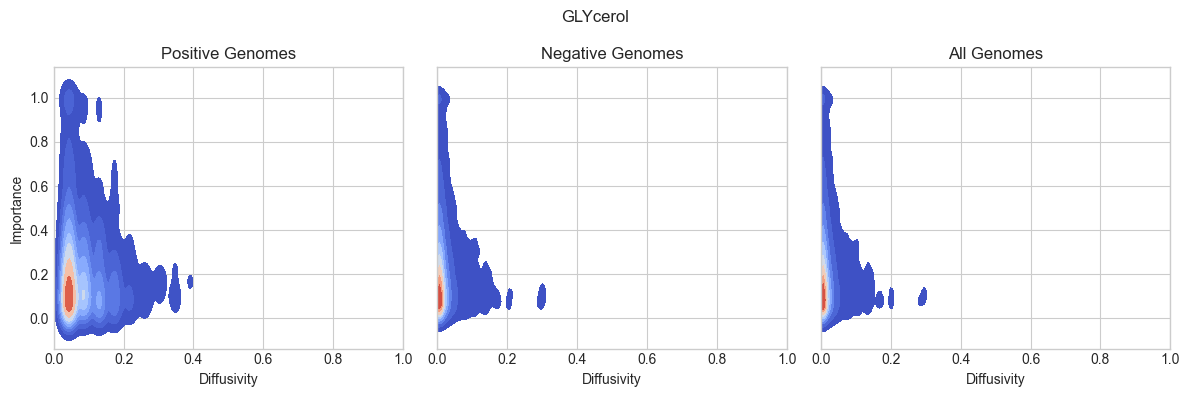

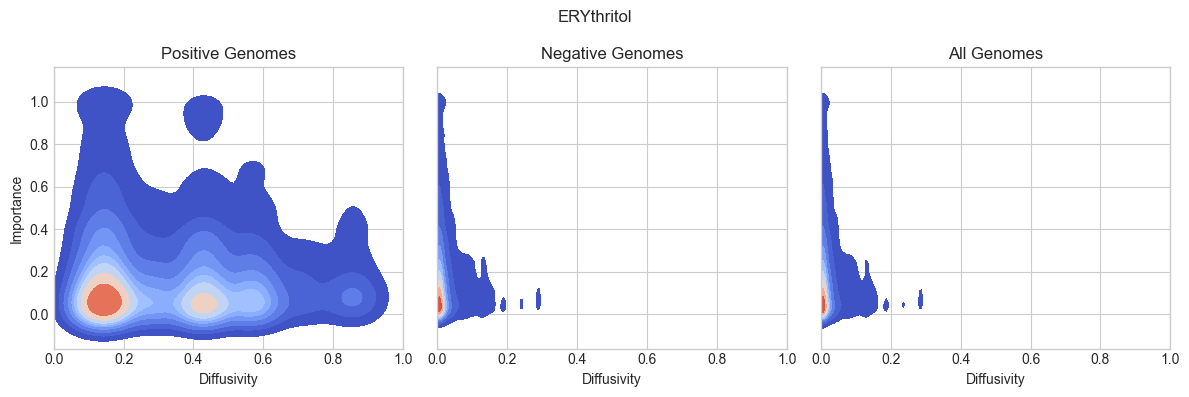

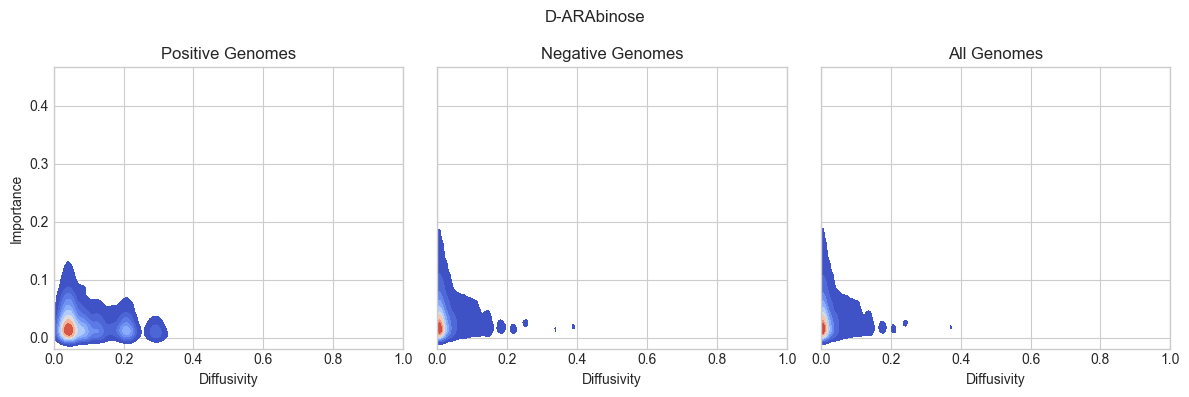

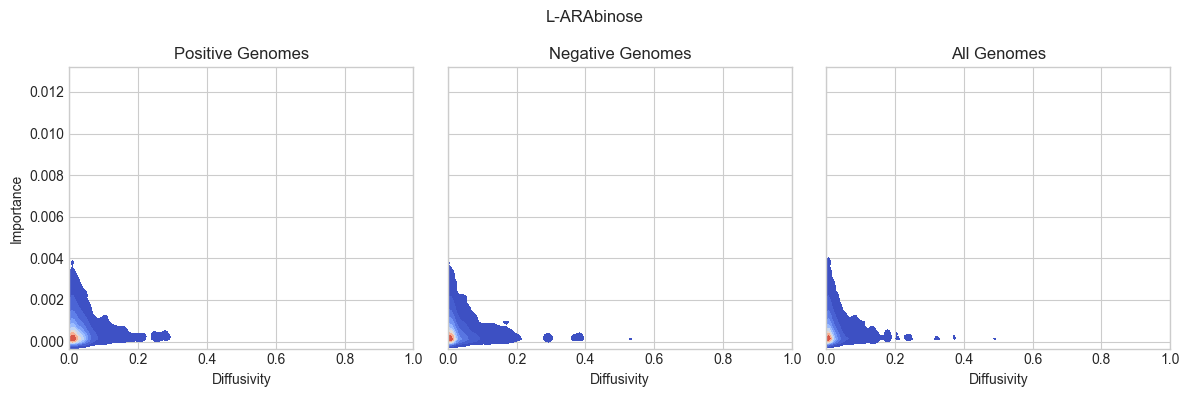

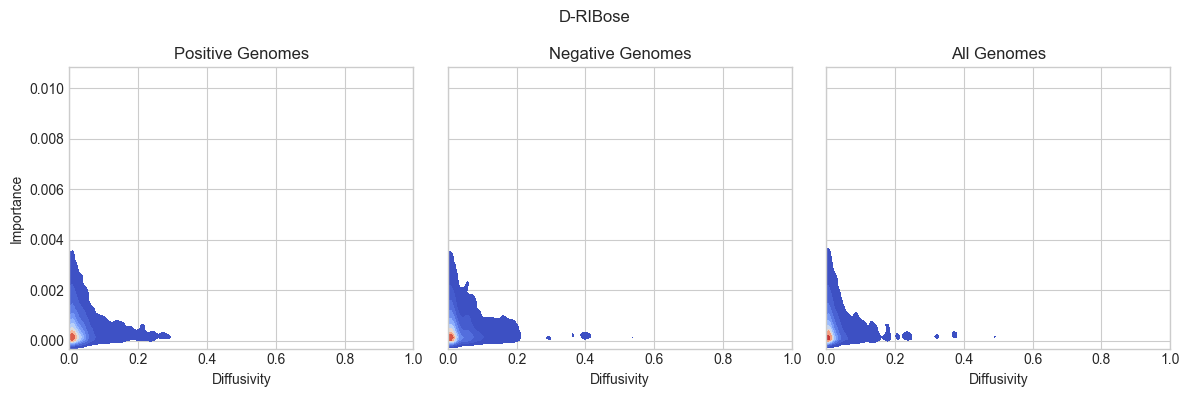

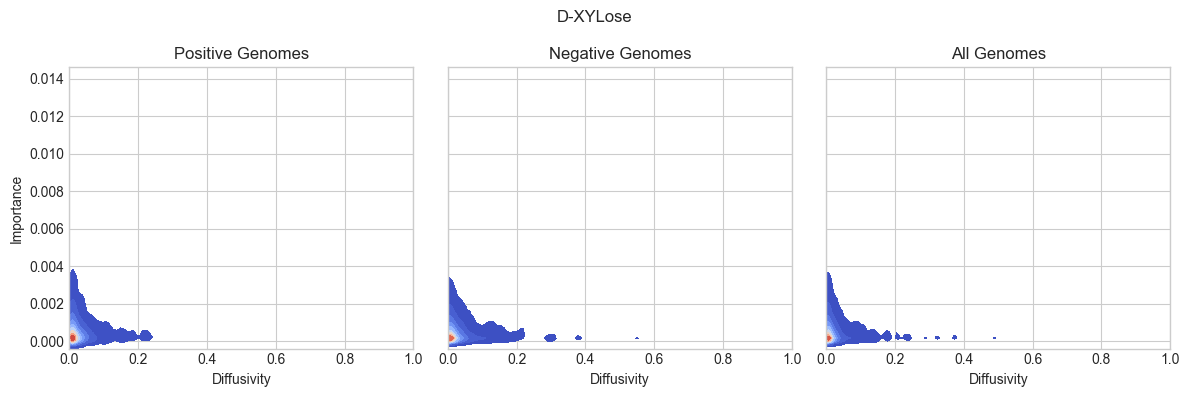

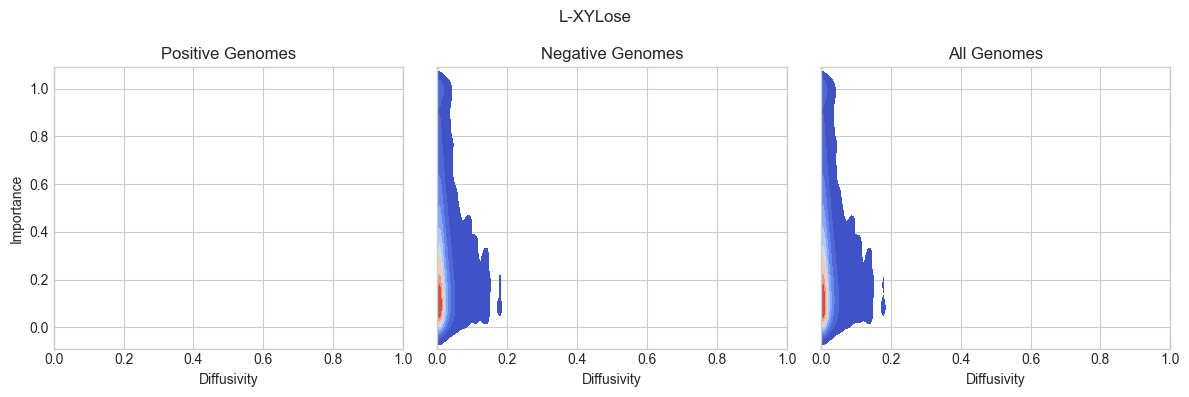

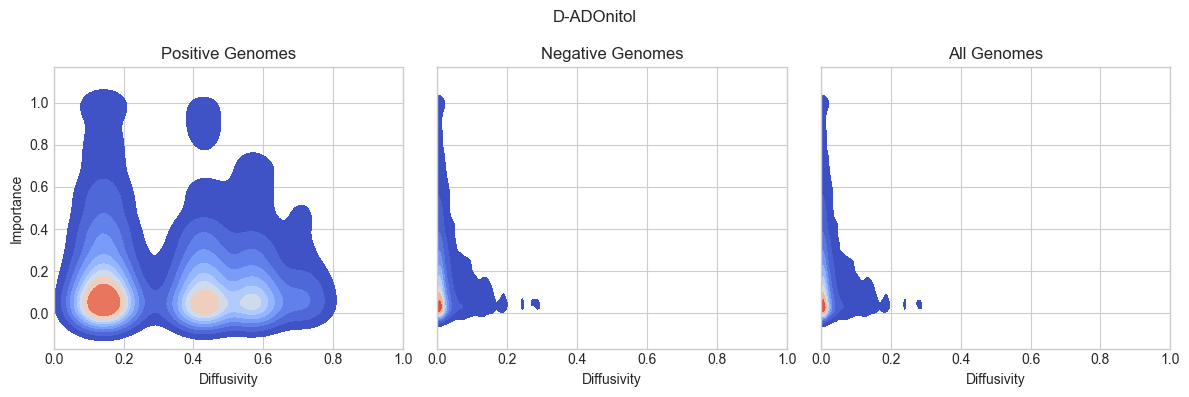

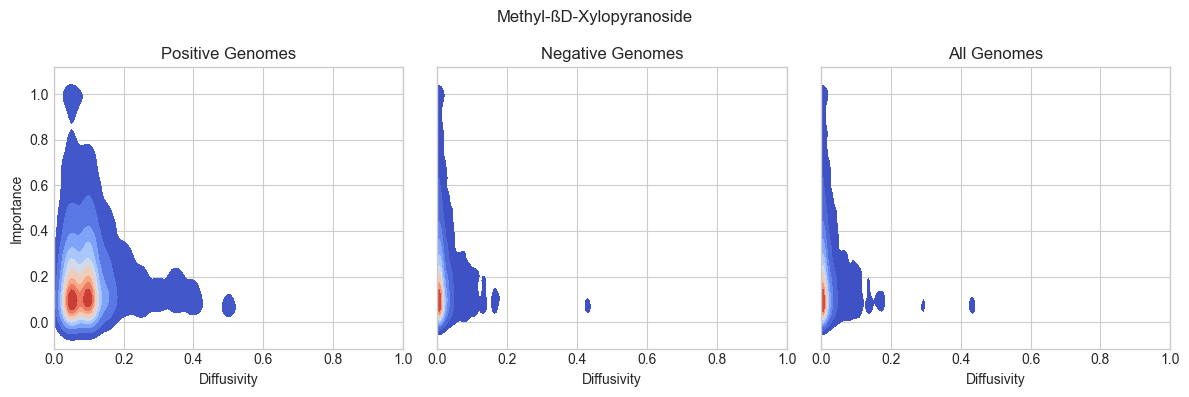

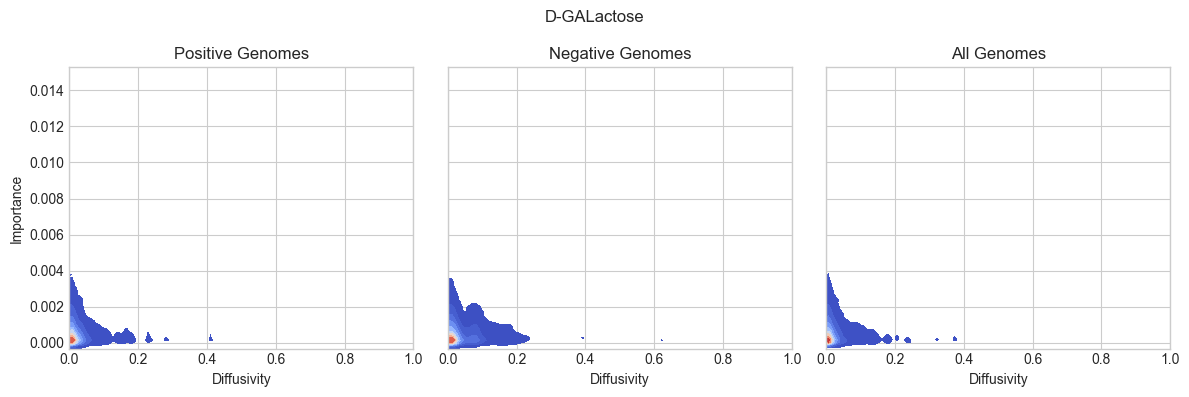

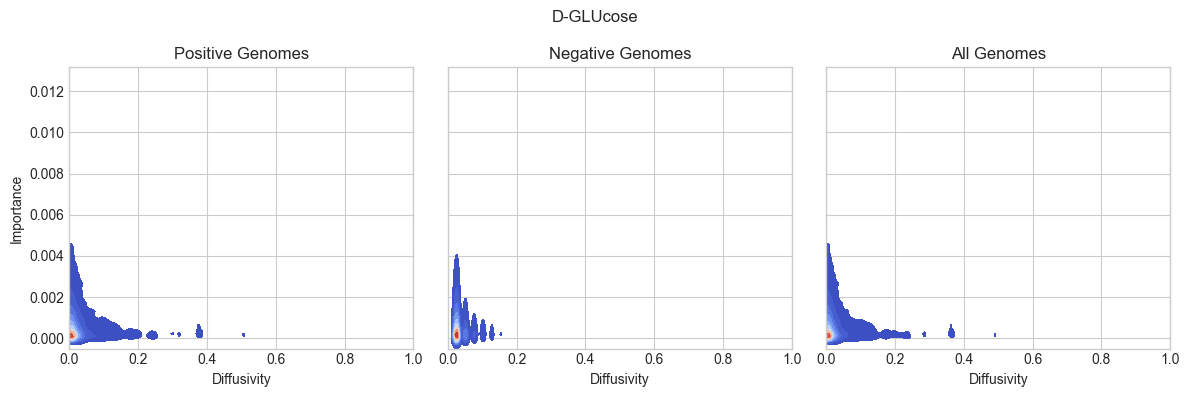

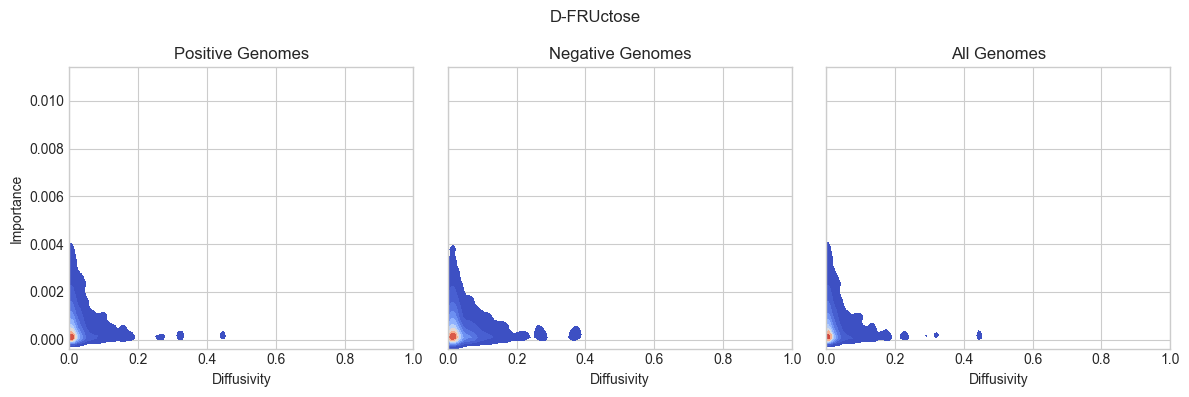

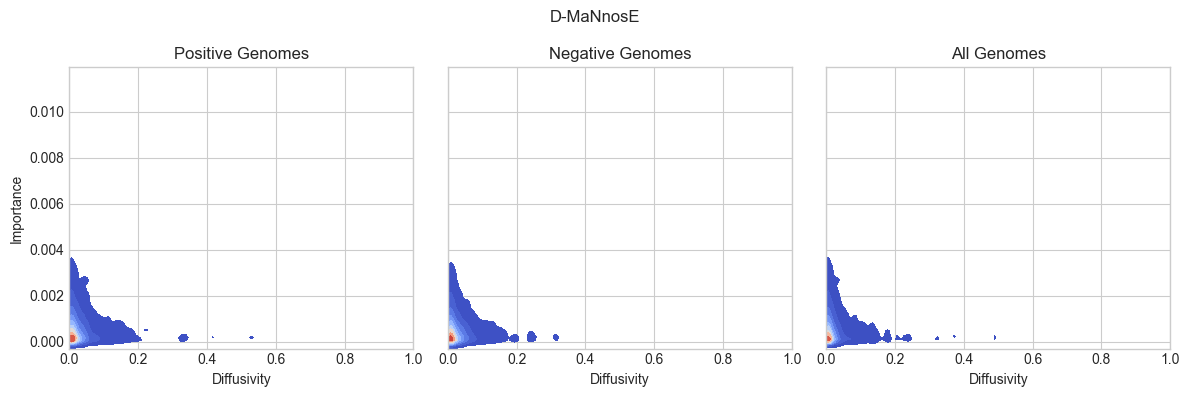

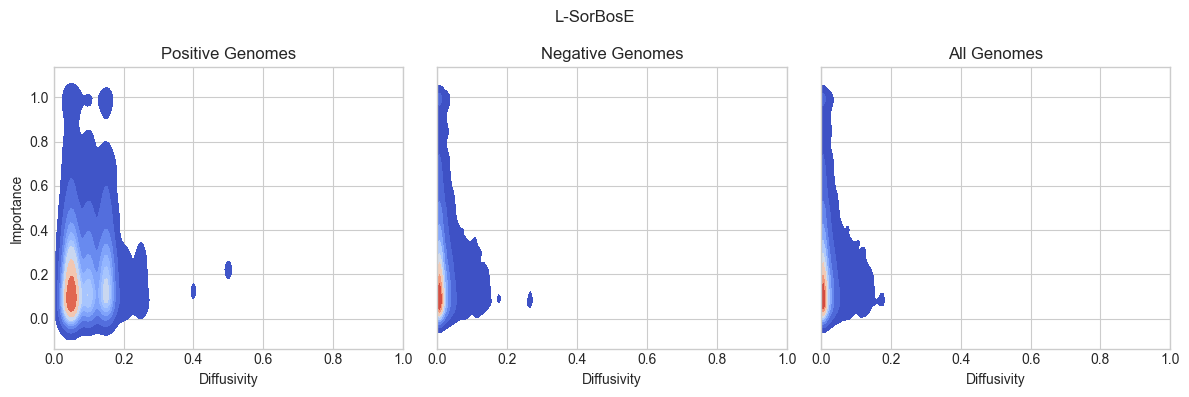

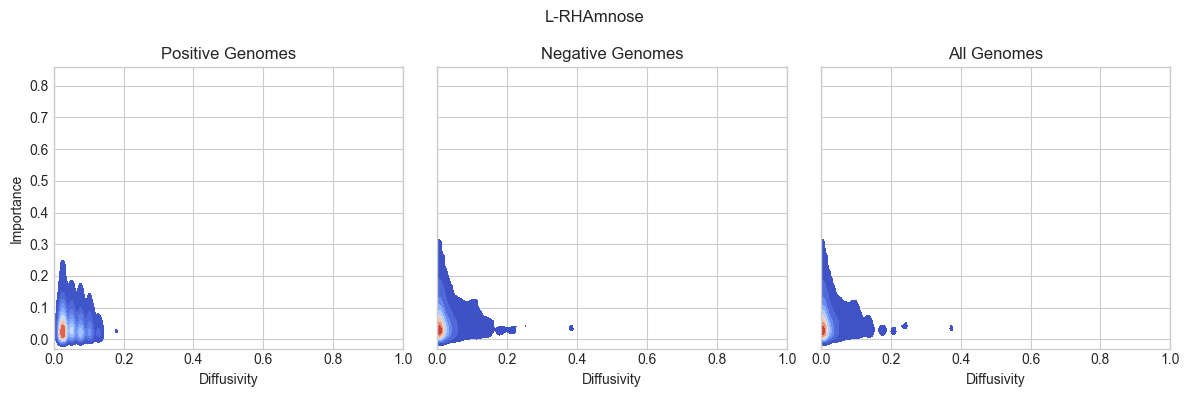

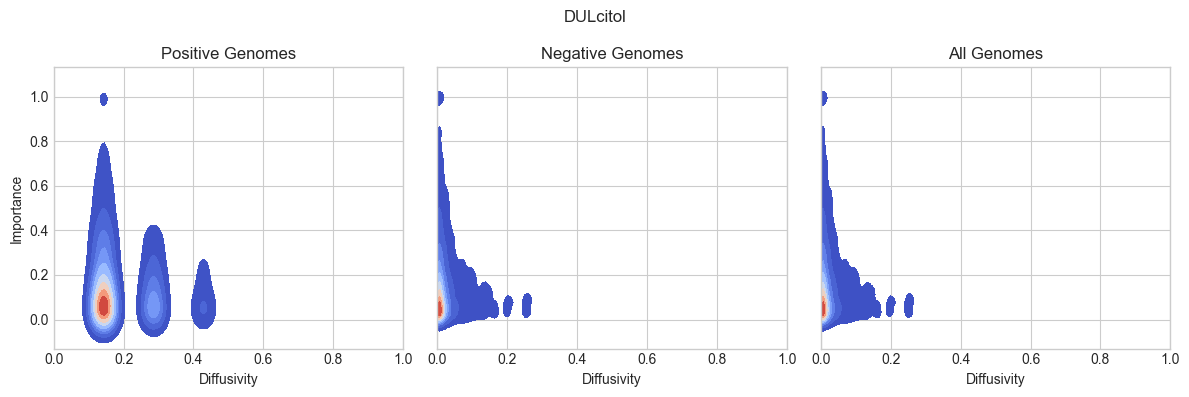

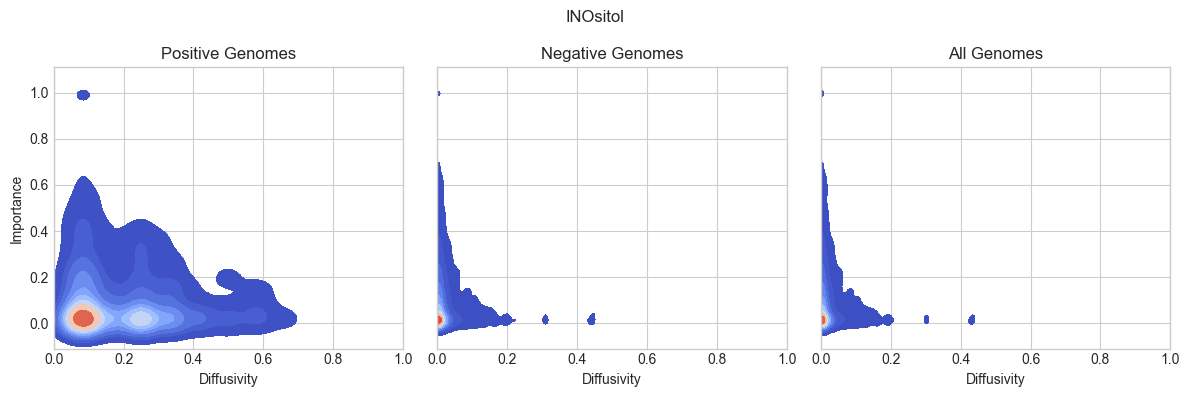

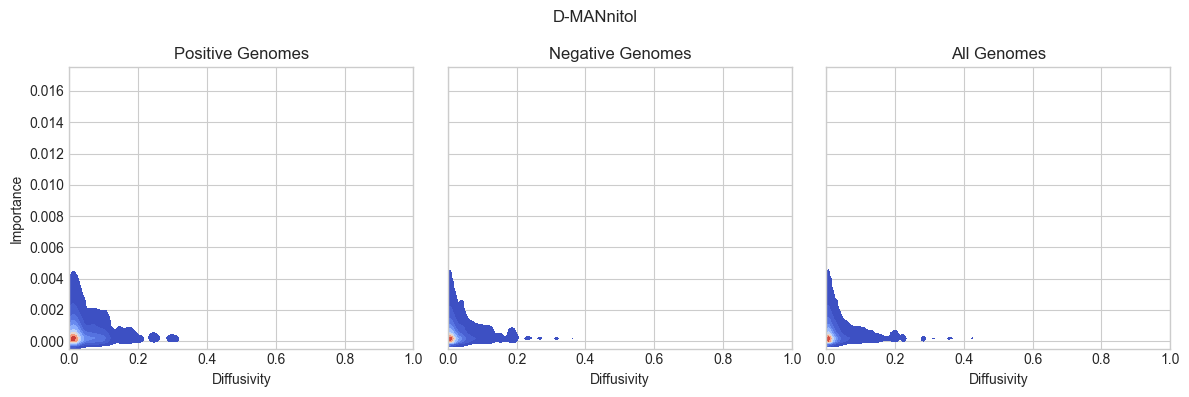

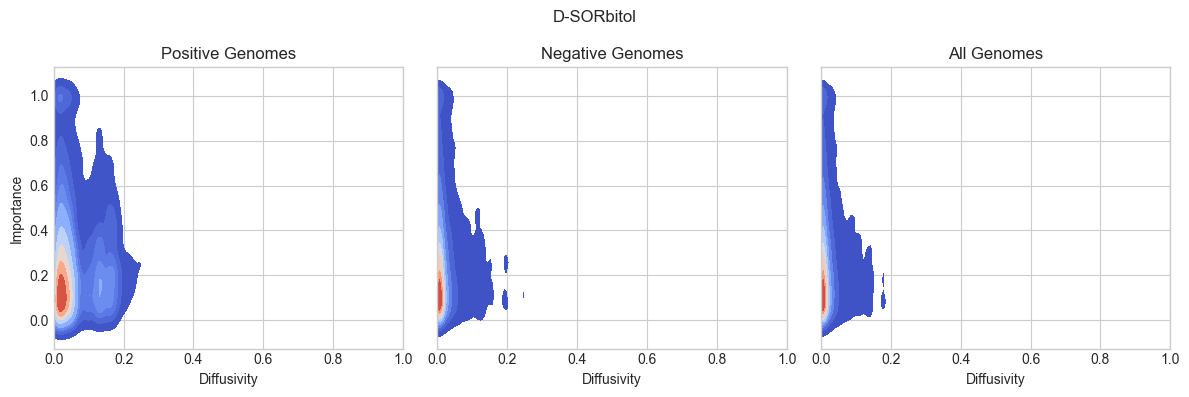

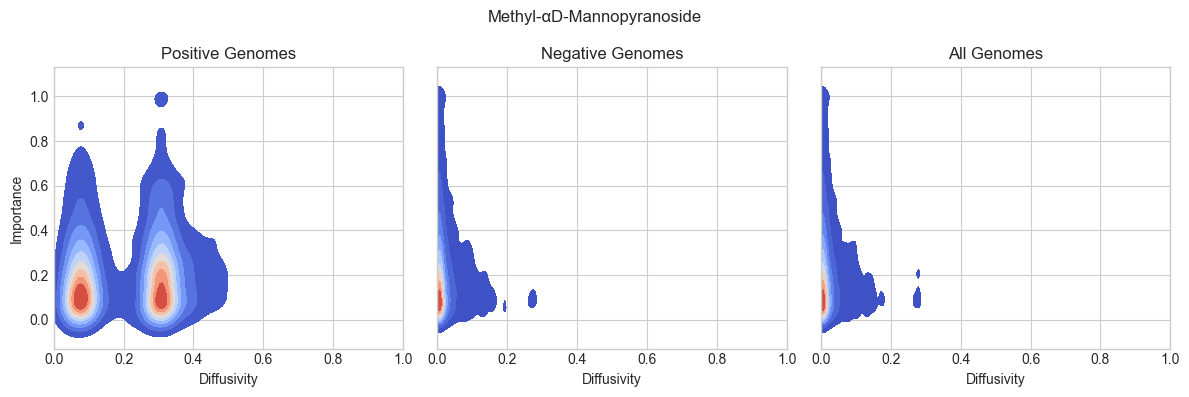

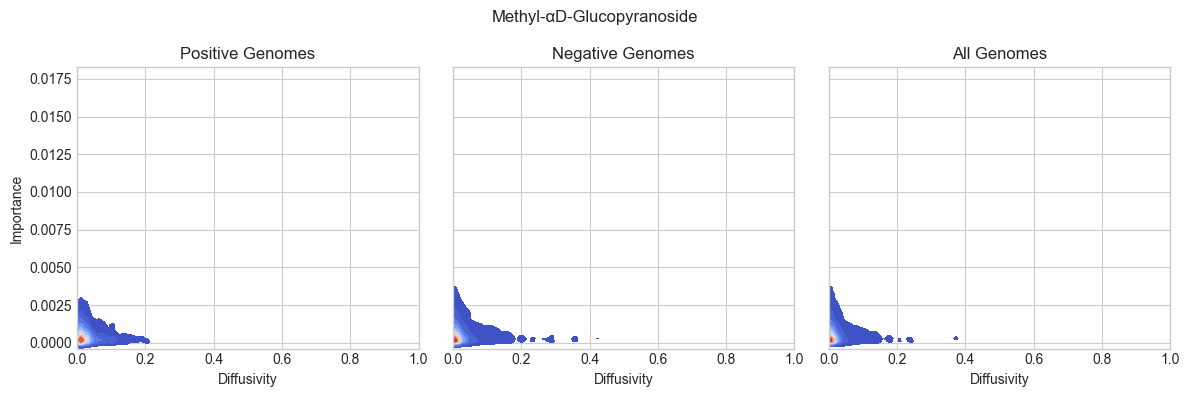

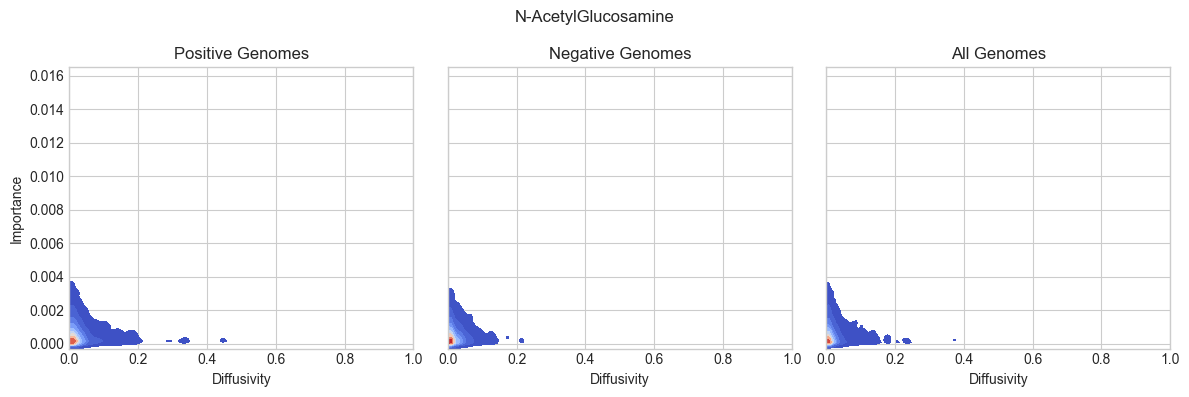

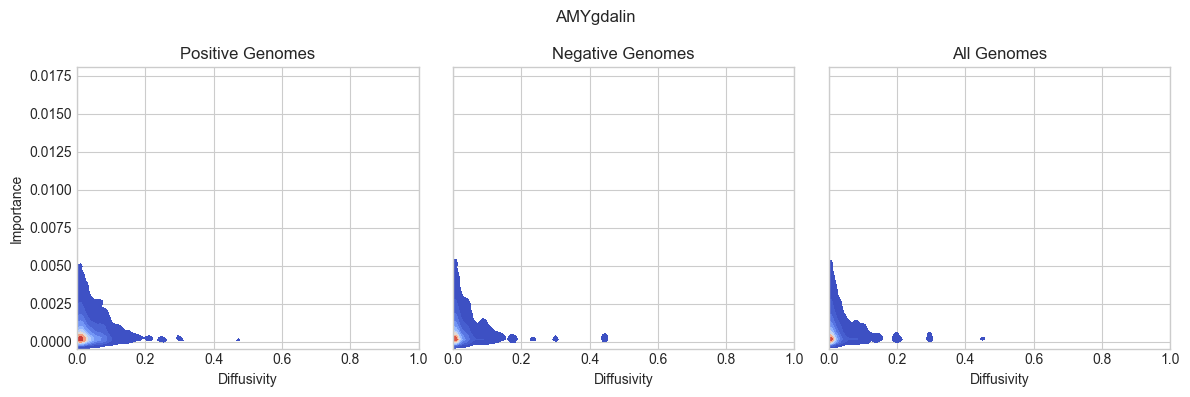

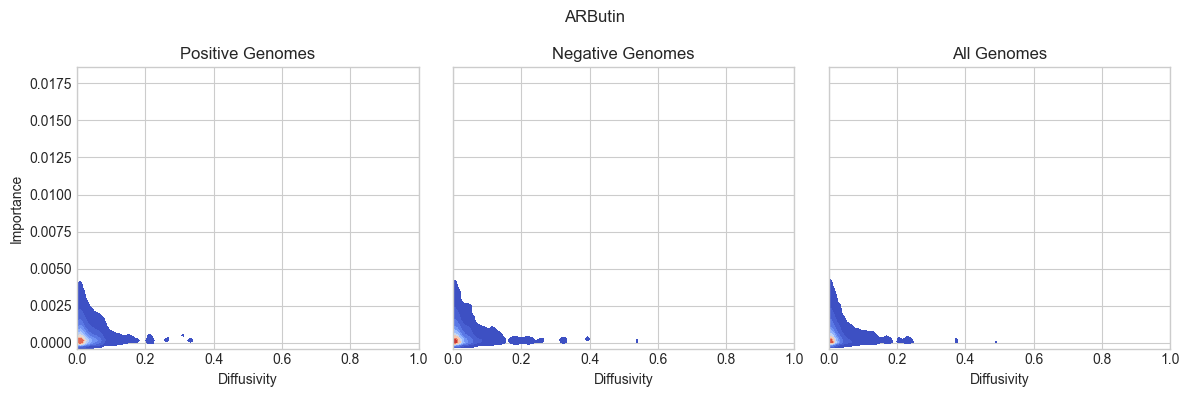

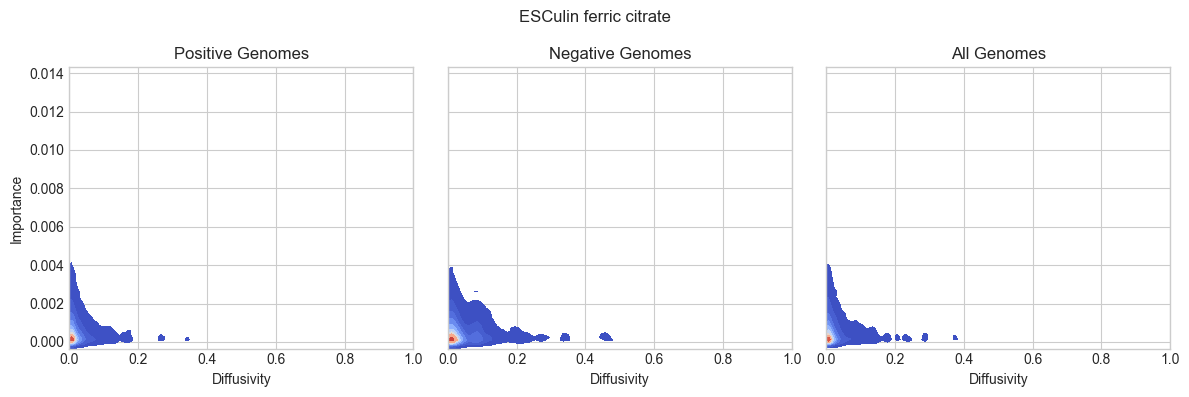

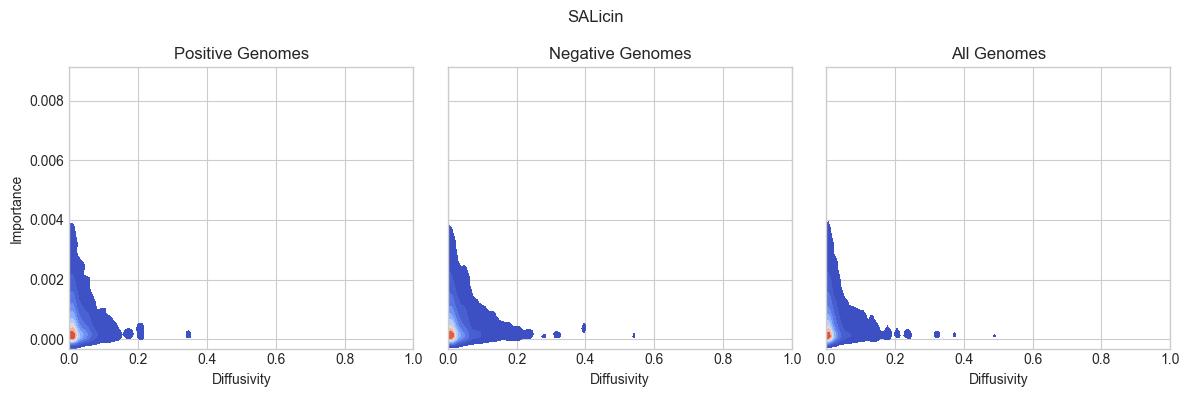

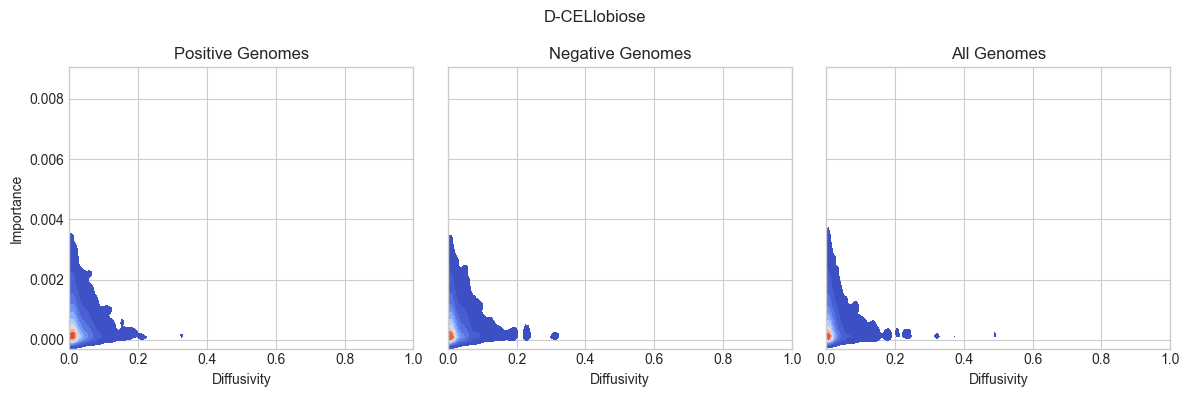

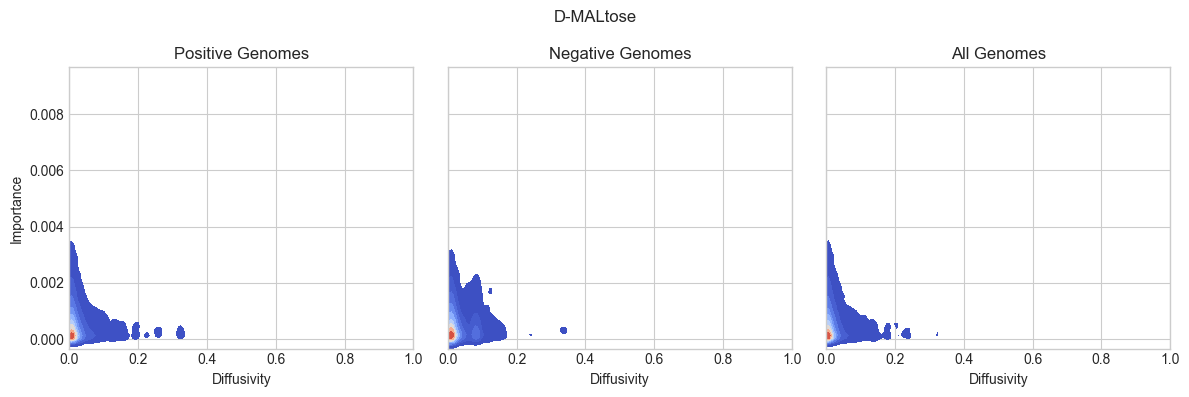

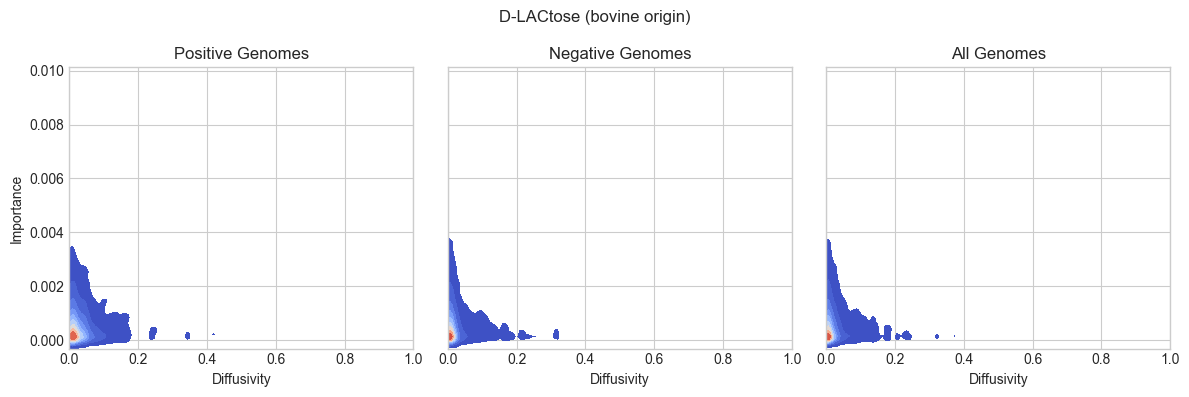

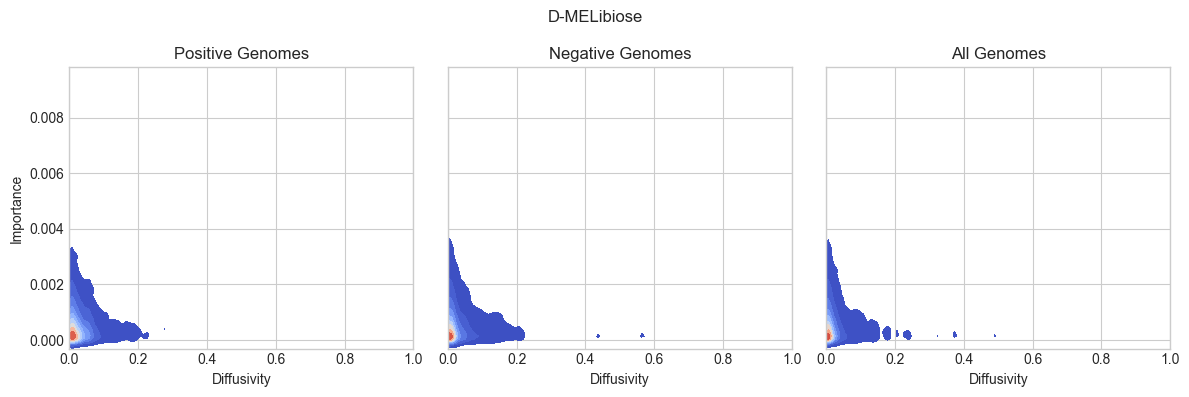

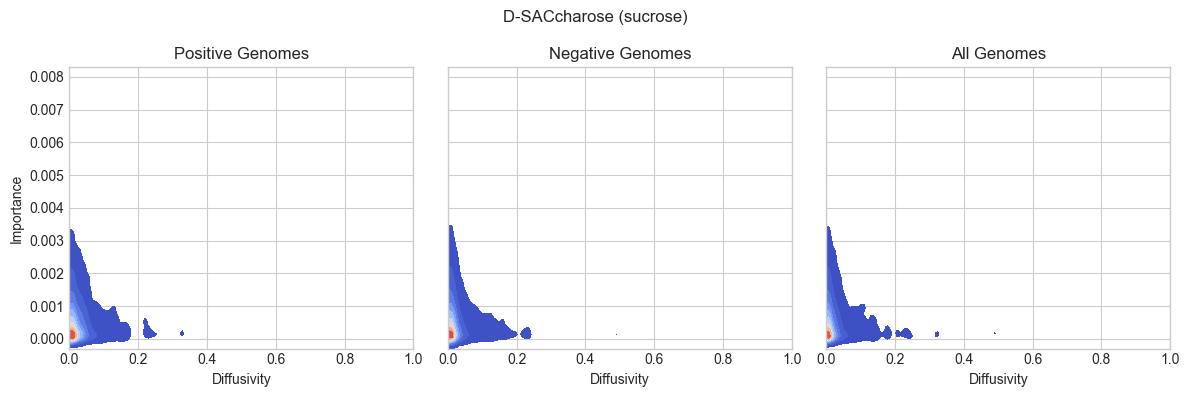

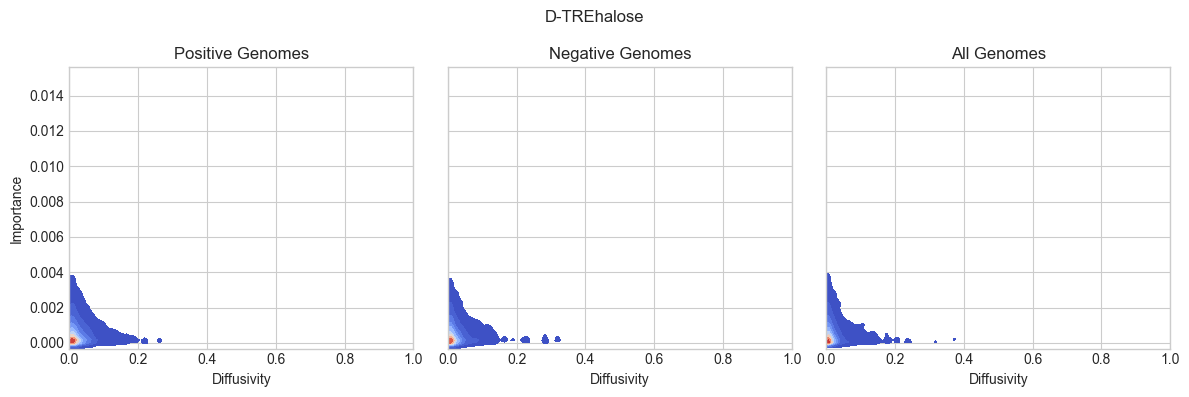

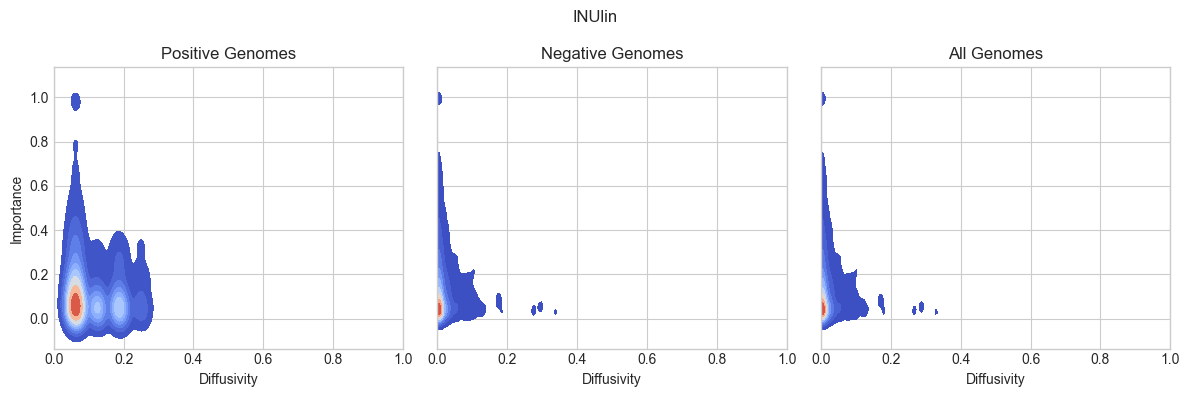

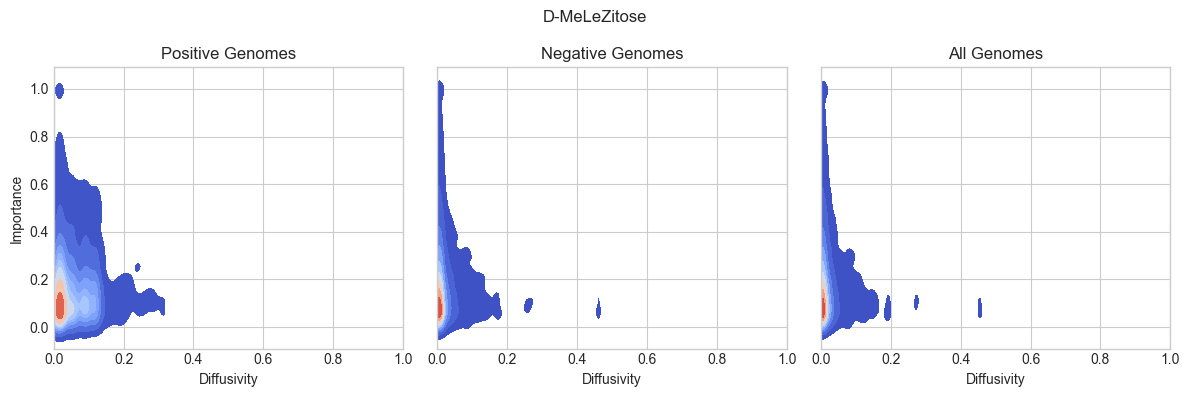

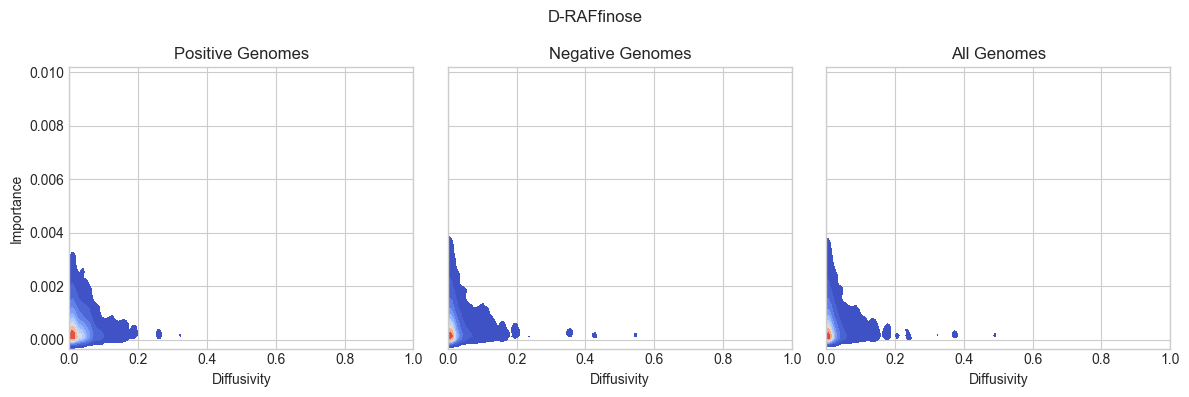

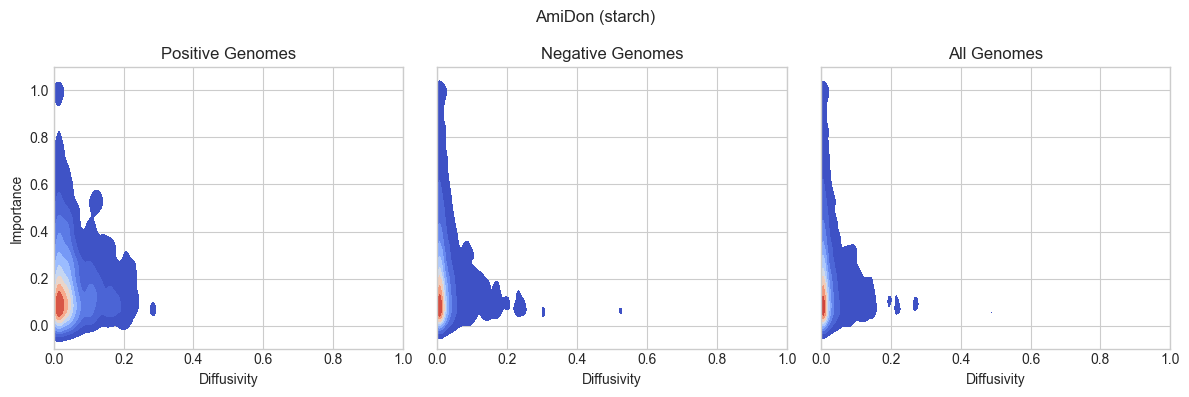

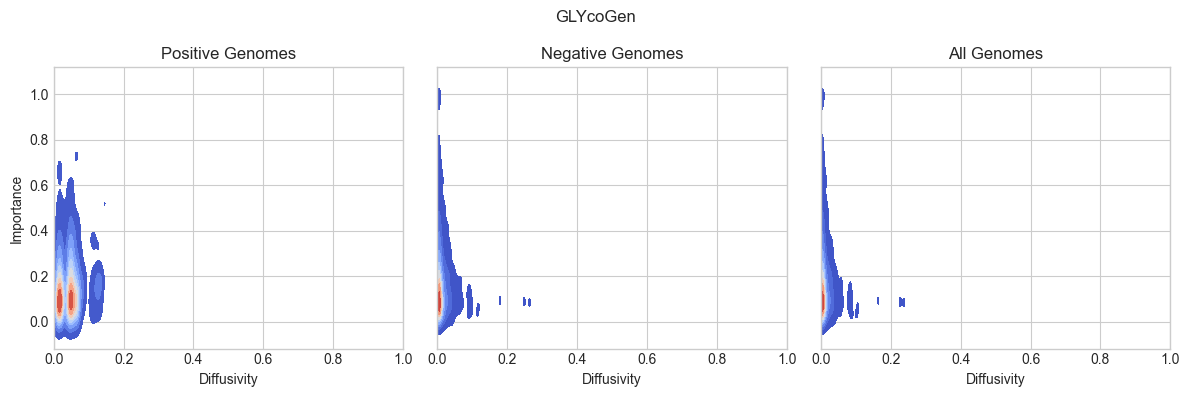

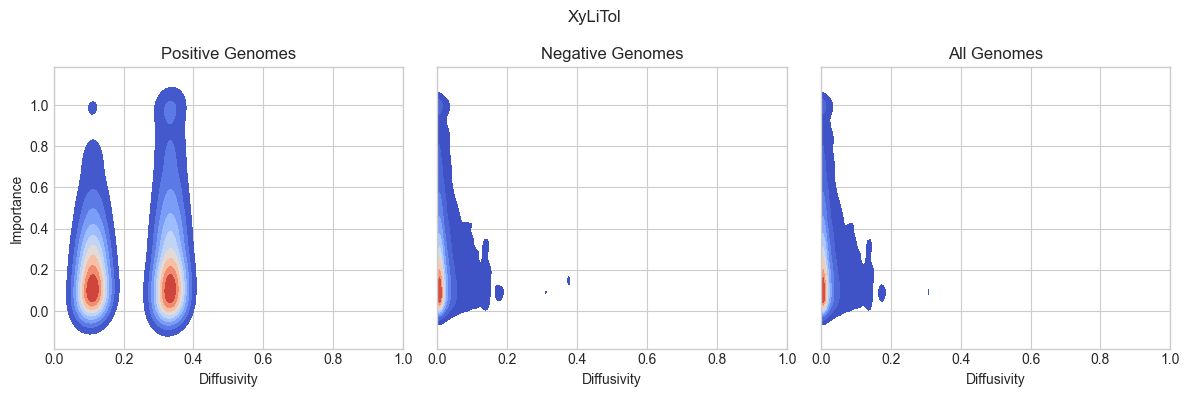

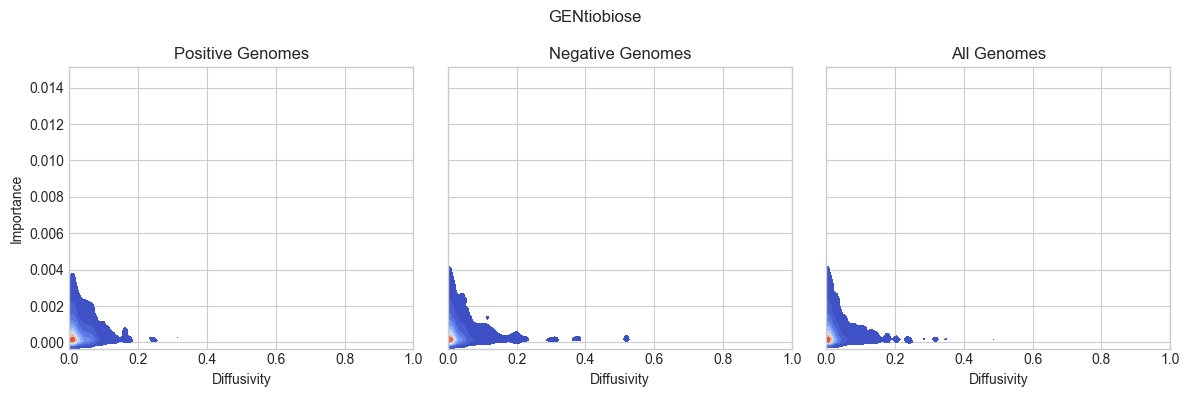

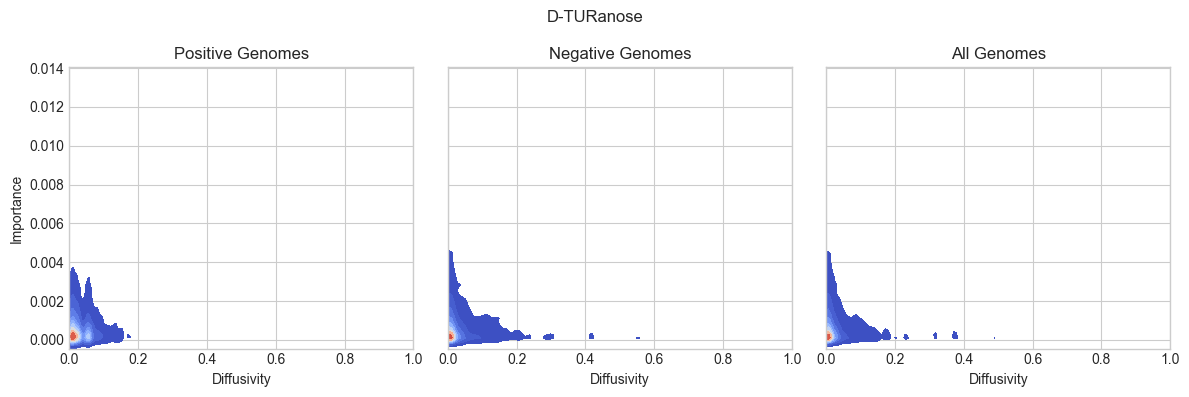

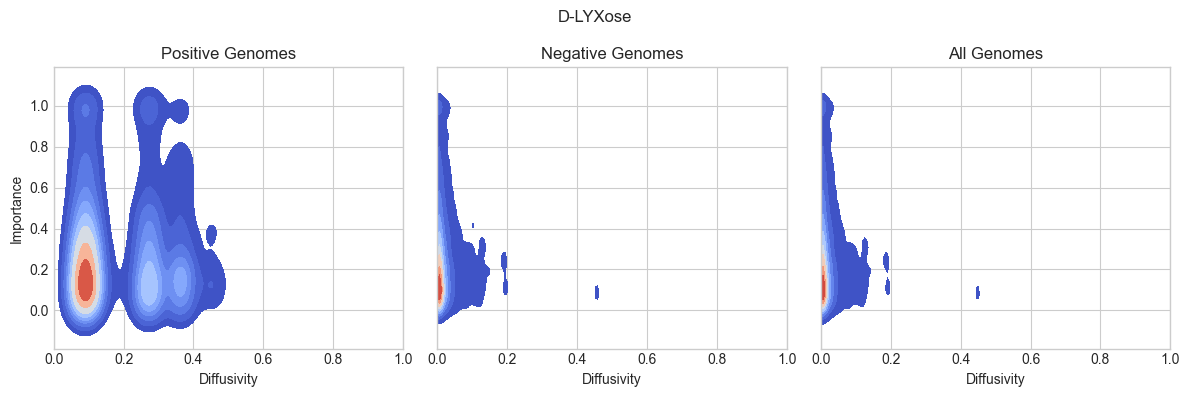

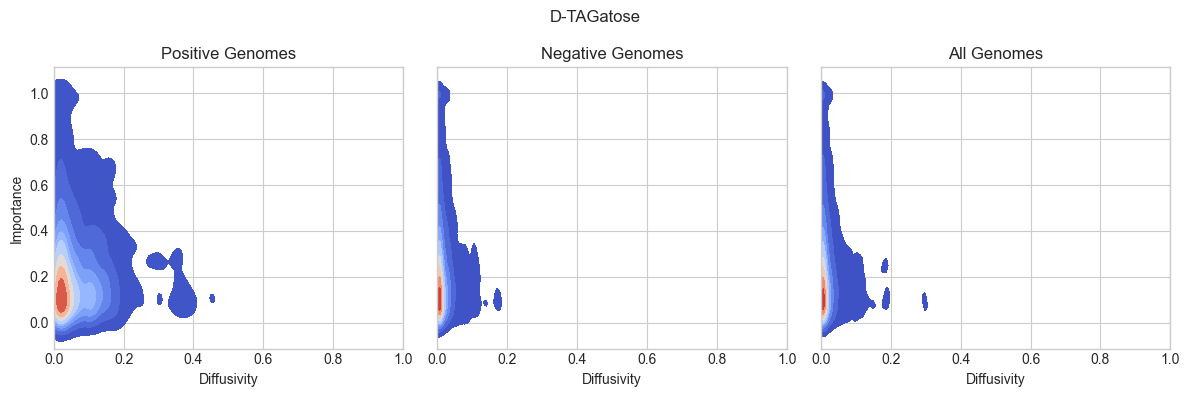

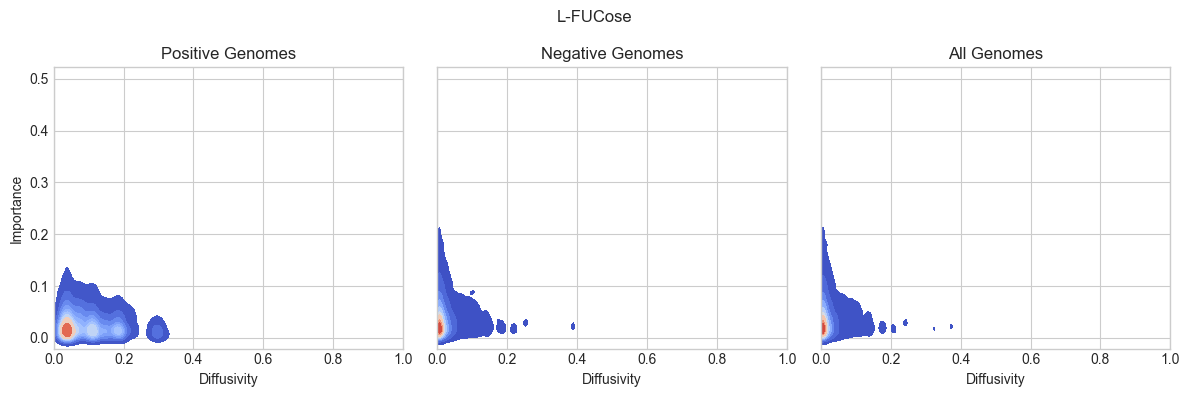

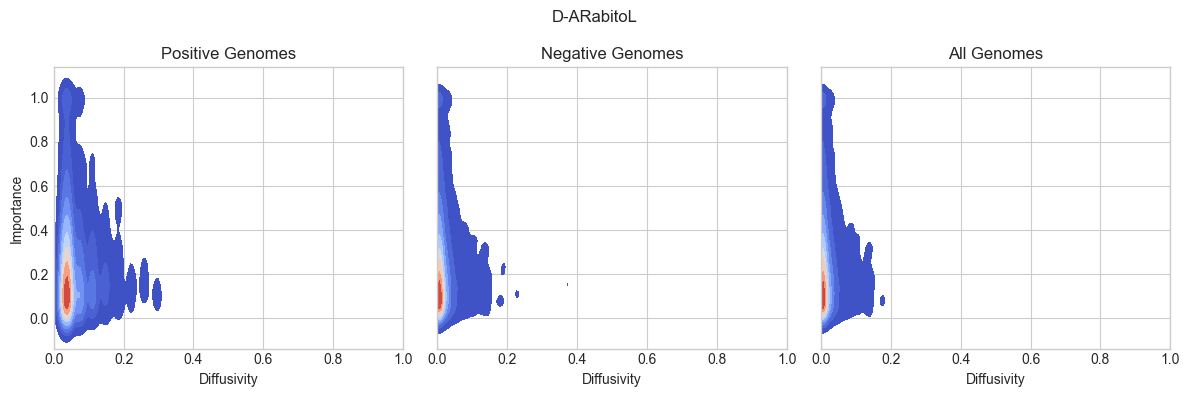

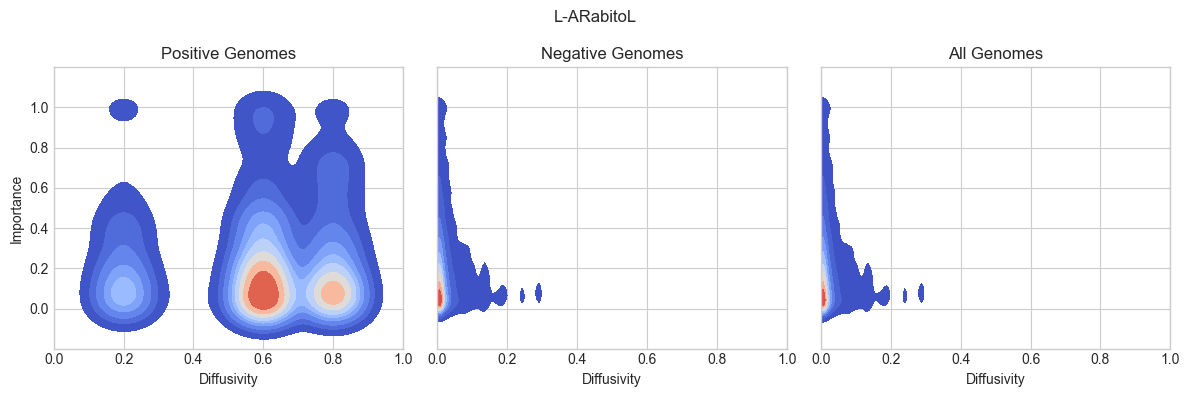

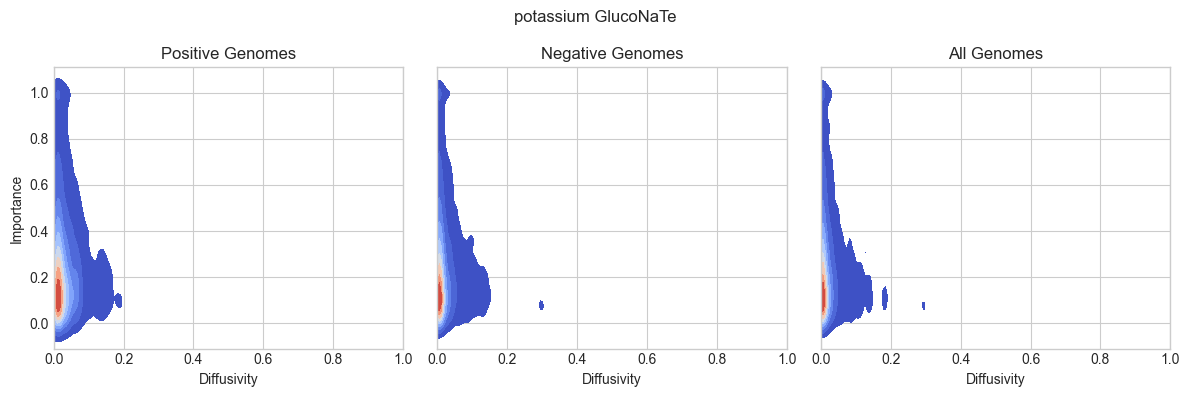

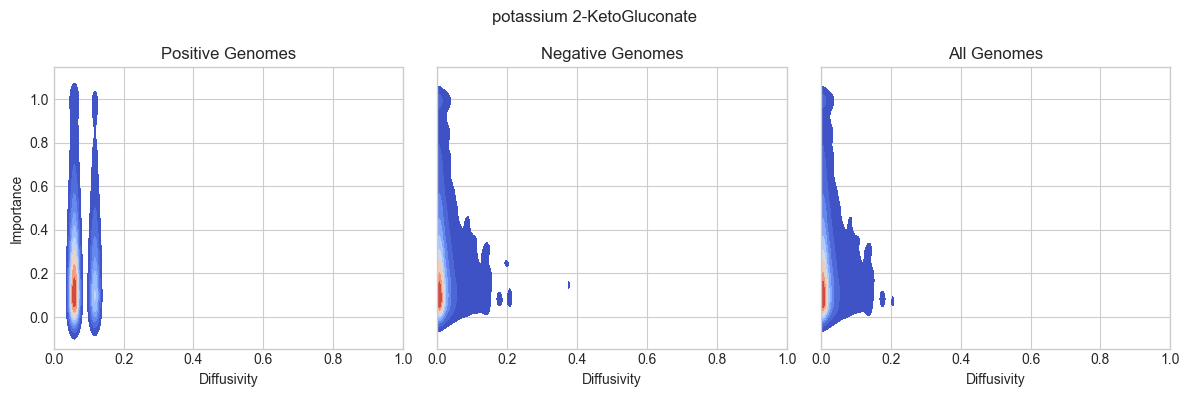

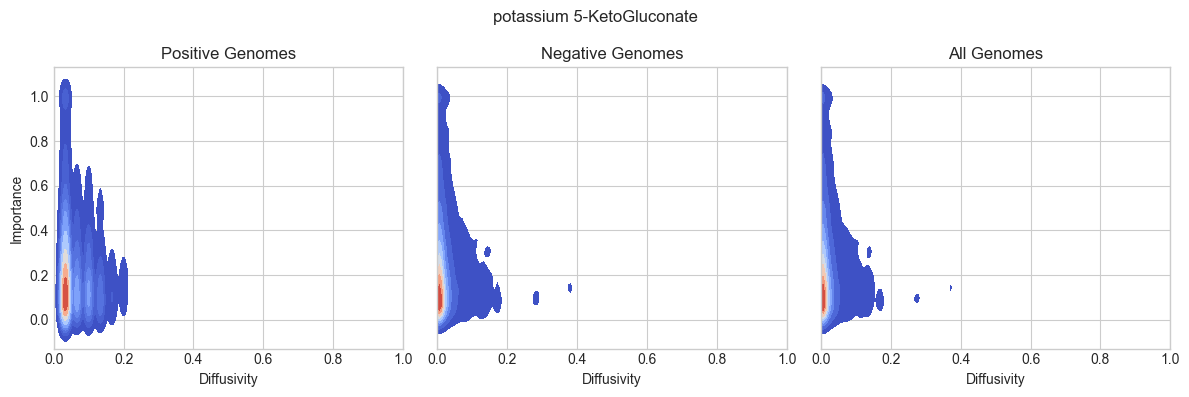

In [48]:
_, y = process_data("Data/")

# Se non si hanno a disposizione le importanze, decommentare
# gene_families = parse_clus(path="Result/PanDelos-plus/out.clus")
# gene_importances = gene_importances_pandelos(gene_families, y)

path = "Result/Coverages/Gene_Importances_Pandelos"
files = [os.path.splitext(f)[0] for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
_, y = process_data("Data/")

for carbohydrate in y.columns:
    if carbohydrate not in files:
        continue

    importances = pd.read_excel(f"Result/Coverages/Gene_Importances_Pandelos/{carbohydrate}.xlsx")
    importances = importances[importances['Importance'].notna() & (importances['Importance'] != 0)]

    positive_strain = y[y[carbohydrate] == 1].index.astype(str).tolist()
    negative_strain = y[y[carbohydrate] == 0].index.astype(str).tolist()

    positives = importances[importances['Strain'].isin(positive_strain)]
    negatives = importances[importances['Strain'].isin(negative_strain)]
    all_genes = importances

    # display(positives[positives['Gene family'] == 51])

    # Calcolo diffusività per ogni gruppo
    def compute_diffusivity(df):
        diffusivity = df.groupby('Gene family')['Strain'].nunique()
        diffusivity = diffusivity.reset_index()
        diffusivity.columns = ["Gene family", "Diffusivity"]
        diffusivity = diffusivity[['Gene family', 'Diffusivity']].drop_duplicates()
        
        return df.merge(diffusivity, on="Gene family", how="left")

    positives = compute_diffusivity(positives)
    negatives = compute_diffusivity(negatives)
    all_genes = compute_diffusivity(all_genes)

    print(f"Plotting {carbohydrate}")
    plot_diffusivity_importance(positives, negatives, all_genes, y, carbohydrate)
    # plot_diffusivity_importance(positives, negatives, all_genes, y, carbohydrate, lim=False)

display(positives.sort_values(by='Importance', ascending=False))


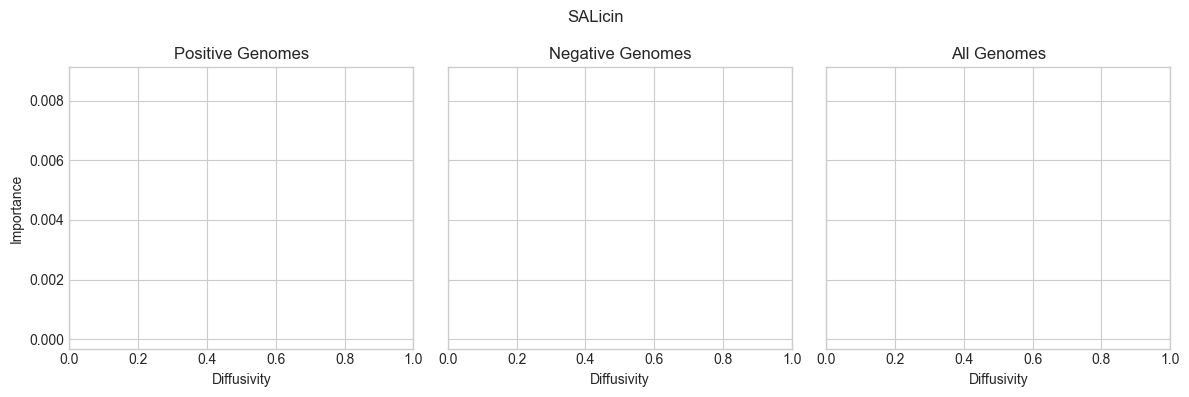

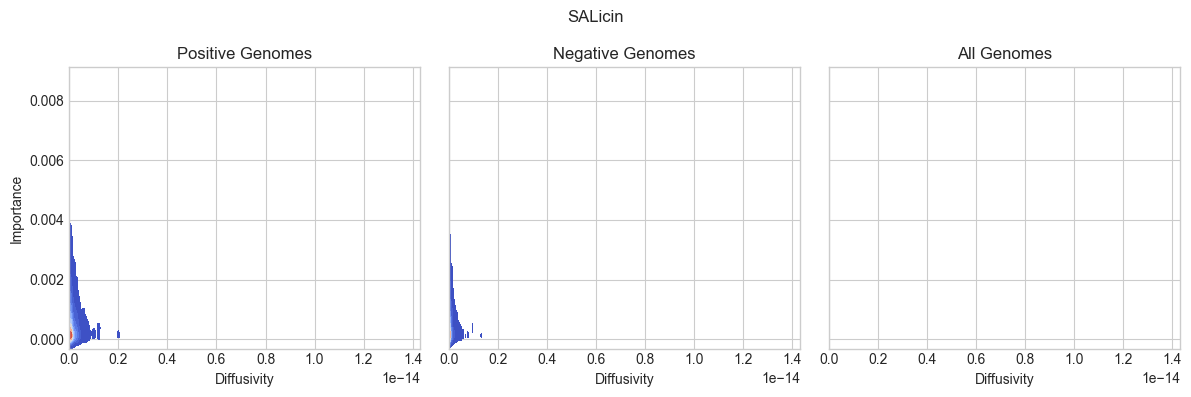

In [ ]:
# display(positives.sort_values(by='Diffusivity', ascending=False))

# _, y = process_data("Data/")

plot_diffusivity_importance(positives, negatives, all_genes, y, 'SALicin', lim=False)

